### Experiment: Single Objective Variance of True Probablity

#### Aim

The objective of the **individual** is to simply increase variance added per row to the **population's** true_probablity per row.

#### How does it make sure the accuracy is also increasing?

If the true_p per row is not greater than a threshold say 0.6, then the variance added for that row is zero. This makes sure that bad performing individuals are punished.

#### Critism

Does nothing  directly to promote individuals which would help increase the population true_mean_probablity for rows at which it currently does bad. 

### Todo:
- Convert into multi objective function and add accuracy measure.
- Try to make the final ensemble out of the pareto front.
- Add constraints to the GPs output.





In [1]:
from collections import Counter
def predict_holdout(pop, subspace=False):
    forest_predictions = []
    sample_sizes = []
    for ind_num, individual in enumerate(pop):
        func = toolbox.compile(expr=individual)
    #     print individual
        sample_counts = [int(func(*record)) for record in X_train]
        sample_counts = [max(min(sample_count, max_features), 0) for sample_count in sample_counts]
        sample = []
        for sample_index, sample_count in enumerate(sample_counts):
            sample.extend([sample_index] * sample_count)
        sample = np.array(sample)
        
        if len(sample) == 0:
            continue
        
        sample_sizes.append(X_train[sample].shape[0])

        clf = DecisionTreeClassifier(random_state=34092)
        
        X = X_train[sample]
        y = y_train[sample]
        
        if subspace==True:
            X = pd.DataFrame(X).sample(n=int(np.sqrt(X.shape[1])), axis=1)
            xcols = X.columns
            
        clf.fit(X, y)
        
        if subspace==True:
            predictions = clf.predict(pd.DataFrame(X_test).loc[:,xcols])
        else:
            predictions = clf.predict(X_test)
        forest_predictions.append(predictions)
    y_pred = np.array(
    [Counter(instance_forest_predictions).most_common(1)[0][0] for instance_forest_predictions in zip(*forest_predictions)])
    
    return np.sum(y_test == y_pred)*1.0 / len(y_test)

In [20]:
import operator
import itertools
import numpy as np

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split

import pandas as pd

np.seterr(all='raise')

dataset = 'GAMETES'

if dataset == 'digit':
    digits = load_digits()
    data_features, data_labels = digits.data, digits.target

if dataset == 'GAMETES':
    df = pd.read_csv('GAMETES-easy-4x2-way_her-0.4_pop-1600_attribs-100_discrete.csv', delimiter='\t')
    data_features, data_labels = df.iloc[:,:-1].values, df.iloc[:, -1].values

print data_features.shape



X_train, X_test, y_train, y_test = train_test_split(data_features, data_labels, stratify=data_labels,
                                                    train_size=0.75, test_size=0.25)


# X_train, X_test, y_train, y_test = train_test_split(X_train_tot, y_train_tot, stratify=y_train_tot,
#                                                     train_size=0.75, test_size=0.25)




# defined a new primitive set for strongly typed GP
pset = gp.PrimitiveSetTyped('MAIN', itertools.repeat(float, data_features.shape[1]), float, 'Feature')

# boolean operators
pset.addPrimitive(operator.and_, [bool, bool], bool)
pset.addPrimitive(operator.or_, [bool, bool], bool)
pset.addPrimitive(operator.not_, [bool], bool)

# floating point operators
# Define a protected division function
def protectedDiv(left, right):
    try: return left / right
    except (ZeroDivisionError, FloatingPointError): return 1.

pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.sub, [float, float], float)
pset.addPrimitive(operator.mul, [float, float], float)
pset.addPrimitive(protectedDiv, [float, float], float)

# logic operators
# Define a new if-then-else function
def if_then_else(in1, output1, output2):
    if in1: return output1
    else: return output2

pset.addPrimitive(operator.lt, [float, float], bool)
pset.addPrimitive(operator.eq, [float, float], bool)
pset.addPrimitive(if_then_else, [bool, float, float], float)

# terminals
pset.addTerminal(False, bool)
pset.addTerminal(True, bool)
for val in np.arange(-10., 11.):
    pset.addTerminal(val, float)

creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Individual', gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('expr', gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('compile', gp.compile, pset=pset)



row_prob = {} # Each key is row index,
row_mean_prob = {}
def update_true_class_variance(pop_):
    
    """
    pop is a list of indiv.
    Each indiv
    """
    global row_prob, row_mean_prob
    row_prob = {} #reset
    row_mean_prob = {}
    
    for individual in pop_:
        func = toolbox.compile(expr=individual)
        sample_counts = [int(func(*record)) for record in X_train]
        sample_counts = [max(min(sample_count, max_features), 0) for sample_count in sample_counts]
        sample = []
        for sample_index, sample_count in enumerate(sample_counts):
            sample.extend([sample_index] * sample_count)
        sample = np.array(sample)
        
        if len(sample) == 0:
            continue

        clf = DecisionTreeClassifier(random_state=34092)
        clf.fit(X_train[sample], y_train[sample])

        probas = clf.predict_proba(X_test)
#         print clf.classes_
        for ix, row in enumerate(probas):
#             print row
            try:
                true_p = row[y_test[ix]]
            except:
                true_p = np.nan
            try:
                row_prob[ix].append(true_p)
            except:
                row_prob[ix] = [true_p]
#                 print row_prob[ix]
    
#     print 'row_prob', row_prob
    for key in row_prob.keys():
        row_mean_prob[key] = np.nanmean(row_prob[key])
    
    return    


def update_true_class_variance_v2(pop_):
    
    """
    pop is a list of indiv.
    Each indiv
    """
    global row_prob, row_mean_prob
    row_prob = {} #reset
    row_mean_prob = {}
    
    for individual in pop_:
        func = toolbox.compile(expr=individual)
        sample_counts = [int(func(*record)) for record in X_train]
        sample_counts = [max(min(sample_count, max_features), 0) for sample_count in sample_counts]
        train_sample = []
        test_sample = []
        for sample_index, sample_count in enumerate(sample_counts):
            if sample_count>0:
                train_sample.extend([sample_index] * sample_count)
            else:
                test_sample.extend([sample_index])
        
        train_sample = np.array(train_sample)
        test_sample = np.array(test_sample)
        
        if len(test_sample) == 0 or len(train_sample)==0:
            continue

        clf = DecisionTreeClassifier(random_state=34092)
        clf.fit(X_train[train_sample], y_train[train_sample])

        probas = clf.predict_proba(X_train)
#         print clf.classes_
        for ix, row in enumerate(probas):
            if ix in test_sample:
                try:
                    true_p = row[y_train[ix]]
                except:
                    true_p = np.nan
            else:
                true_p = np.nan
            
            try:
                row_prob[ix].append(true_p)
            except:
                row_prob[ix] = [true_p]
#                 print row_prob[ix]
    
#     print 'row_prob', row_prob
    for key in row_prob.keys():
        row_mean_prob[key] = np.nanmean(row_prob[key])
    
    return    


def evaluate_individual(individual):
    global row_mean_prob
    # Transform the tree expression into a callable function
    func = toolbox.compile(expr=individual)
    sample_counts = [int(func(*record)) for record in X_train]
    sample_counts = [max(min(sample_count, max_features), 0) for sample_count in sample_counts]
    train_sample = []
    test_sample = []
    for sample_index, sample_count in enumerate(sample_counts):
        if sample_count>0:
            train_sample.extend([sample_index] * sample_count)
        else:
            test_sample.extend([sample_index])
    
    train_sample = np.array(train_sample)
    test_sample = np.array(test_sample)
    
    
    if len(train_sample) == 0:
        return 1e-20,
    
    if len(test_sample) == 0: #doubt whether we should punish no samples being left out.
        return 1e-20, 
    
    clf = DecisionTreeClassifier(random_state=34092)
    clf.fit(X_train[train_sample], y_train[train_sample])
    score = clf.score(X_train[test_sample], y_train[test_sample])
    
    
    
    probas = clf.predict_proba(X_train)
    total_variance = []
    for ix, row in enumerate(probas):
        if ix in test_sample:
            try:
                true_p = row[y_test[ix]]
            except:
                true_p = 0
            mean_p = row_mean_prob[ix]


            if true_p>=0.65:
                added_variance = (mean_p - true_p)**2
    #         elif true_p>mean_p: #Giving more score to individuals helping with low mean true_p
    #             added_variance = (mean_p-true_p)**2
            else:
                added_variance = np.nan #Should this be nan?
        else:
            added_variance = np.nan

        total_variance.append(added_variance)
    
    mean_variance_added = np.sqrt(np.nansum(total_variance))
    
    return mean_variance_added,
    
toolbox.register('evaluate', evaluate_individual)
#todo: change this according to multi-objective
toolbox.register('select', tools.selTournament, tournsize=3)
# toolbox.register('select', tools.selNSGA2)

toolbox.register('mate', gp.cxOnePoint)
toolbox.register('expr_mut', gp.genFull, min_=0, max_=3)
toolbox.register('mutate', gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

population = toolbox.population(n=100)
halloffame = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register('std', np.std)
stats.register('min', np.min)
stats.register('avg', np.mean)
stats.register('max', np.max)

clf = DecisionTreeClassifier(random_state=34092)
clf.fit(X_train, y_train)
print('Base DecisionTreeClassifier accuracy: {}'.format(clf.score(X_test, y_test)))

clf = RandomForestClassifier(random_state=34092, n_estimators=100)
clf.fit(X_train, y_train)
print('Base RandomForestClassifier accuracy: {}'.format(clf.score(X_test, y_test)))

clf = GradientBoostingClassifier(random_state=34092)
clf.fit(X_train, y_train)
print('Base GradientBoostingClassifier accuracy: {}'.format(clf.score(X_test, y_test)))

print('')

cxpb = 0.5
mutpb = 0.5
ngen = 30
verbose = True
holdout_perf = {}
max_features = 5

logbook = tools.Logbook()
logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])


update_true_class_variance_v2(population)

# Evaluate the individuals with an invalid fitness ~
invalid_ind = [ind for ind in population if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

if halloffame is not None:
    halloffame.update(population)

record = stats.compile(population) if stats else {}
logbook.record(gen=0, nevals=len(invalid_ind), **record)
if verbose:
    print(logbook.stream)

# Begin the generational process
for gen in range(1, ngen + 1):
    # Select the next generation individuals
    offspring = toolbox.select(population, len(population))

    # Vary the pool of individuals
    offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
#     invalid_ind = [ind for ind in offspring] ## Evaluate everyone.
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Update the hall of fame with the generated individuals
    if halloffame is not None:
        halloffame.update(offspring)

    # Replace the current population by the offspring
    population[:] = offspring

    #Generate true class predict_proba variance for each row.
    update_true_class_variance_v2(population)
    
    # Append the current generation statistics to the logbook
#     fits = pd.DataFrame()
#     fits['score'] = map(lambda x: x.fitness.values[0], population)
#     fits['contrib_variance'] = map(lambda x: x.fitness.values[1], population)
    
    record = stats.compile(population) if stats else {}
    logbook.record(gen=gen, nevals=len(invalid_ind),**record)
    holdout_perf[gen] = predict_holdout(population)
    if verbose:
        print(logbook.stream)
#         print(fits.score.mean())
#         print(fits.contrib_variance.mean())
        print('Performance on hold-out set:', holdout_perf[gen])
str(halloffame[0])

(200, 100)
Base DecisionTreeClassifier accuracy: 0.54
Base RandomForestClassifier accuracy: 0.48
Base GradientBoostingClassifier accuracy: 0.58

gen	nevals	std     	min	avg    	max    
0  	100   	0.881751	0  	1.27759	2.53172
1  	75    	0.692692	1e-20	1.78021	2.53172
('Performance on hold-out set:', 0.41999999999999998)
2  	72    	0.595458	1e-20	1.96642	2.57324
('Performance on hold-out set:', 0.47999999999999998)
3  	72    	0.602433	0    	2.05654	2.69514
('Performance on hold-out set:', 0.46000000000000002)
4  	74    	0.585605	1e-20	2.13726	2.66908
('Performance on hold-out set:', 0.5)
5  	65    	0.611804	1e-20	2.22179	2.70624
('Performance on hold-out set:', 0.56000000000000005)
6  	73    	0.608306	1e-20	2.30956	2.74743
('Performance on hold-out set:', 0.47999999999999998)
7  	68    	0.715241	1e-20	2.28936	2.91698
('Performance on hold-out set:', 0.5)
8  	83    	0.542262	1e-20	2.39996	2.9157 
('Performance on hold-out set:', 0.5)
9  	73    	0.514521	1e-20	2.42384	2.86868
('Performance

'sub(mul(mul(Feature51, Feature13), sub(sub(protectedDiv(Feature50, Feature27), sub(Feature24, Feature74)), protectedDiv(mul(5.0, Feature29), add(Feature87, Feature66)))), mul(protectedDiv(add(Feature55, sub(sub(sub(Feature35, Feature37), if_then_else(not_(or_(True, eq(Feature50, sub(protectedDiv(sub(Feature5, Feature59), add(Feature12, Feature13)), mul(if_then_else(False, Feature71, Feature60), if_then_else(False, Feature48, Feature81)))))), 9.0, Feature29)), protectedDiv(protectedDiv(Feature42, Feature6), protectedDiv(sub(if_then_else(False, sub(Feature84, 3.0), Feature92), if_then_else(False, Feature31, Feature82)), add(sub(Feature16, Feature51), mul(Feature60, Feature31)))))), mul(if_then_else(and_(and_(lt(sub(Feature73, Feature73), protectedDiv(Feature90, Feature41)), False), eq(Feature50, Feature14)), Feature55, sub(add(-1.0, Feature21), sub(Feature94, Feature30))), mul(protectedDiv(Feature47, 9.0), mul(protectedDiv(sub(Feature90, Feature99), if_then_else(False, -5.0, Feature96))

In [19]:
print "Last Gen Holdout", predict_holdout(population, subspace=False)
print "Last Gen w/ Random Subspace Holdout", predict_holdout(population, subspace=True)
print "Pareto w/ Random Subspace Holdout", predict_holdout(halloffame[0:100], subspace=True)
print "Pareto Holdout:", predict_holdout(halloffame[0:100])

Last Gen Holdout 0.52
Last Gen w/ Random Subspace Holdout 0.56
Pareto w/ Random Subspace Holdout 0.56
Pareto Holdout: 0.52


In [13]:
row_mean_prob

{0: 0.66666666666666663,
 1: 0.5,
 2: 0.20000000000000001,
 3: 1.0,
 4: 0.75,
 5: 0.25,
 6: 1.0,
 7: 0.33333333333333331,
 8: 0.0,
 9: 0.59999999999999998,
 10: 1.0,
 11: 1.0,
 12: 0.0,
 13: 0.0,
 14: 1.0,
 15: 0.5,
 16: 0.0,
 17: 1.0,
 18: 0.66666666666666663,
 19: 0.5,
 20: 0.0,
 21: 0.66666666666666663,
 22: 0.0,
 23: 0.33333333333333331,
 24: 1.0,
 25: 0.75,
 26: 1.0,
 27: 1.0,
 28: 0.40000000000000002,
 29: 0.5,
 30: 1.0,
 31: nan,
 32: 0.33333333333333331,
 33: 1.0,
 34: 0.0,
 35: 1.0,
 36: 0.0,
 37: 0.33333333333333331,
 38: 0.25,
 39: 1.0,
 40: 0.25,
 41: 1.0,
 42: 0.25,
 43: 0.5,
 44: 0.80000000000000004,
 45: 0.59999999999999998,
 46: 0.66666666666666663,
 47: 0.0,
 48: 1.0,
 49: 1.0,
 50: 0.0,
 51: nan,
 52: 0.66666666666666663,
 53: 0.16666666666666666,
 54: 0.0,
 55: 0.5,
 56: 0.5,
 57: 0.5,
 58: 0.80000000000000004,
 59: 0.0,
 60: 0.5,
 61: 0.59999999999999998,
 62: 0.66666666666666663,
 63: 1.0,
 64: 0.25,
 65: 0.2857142857142857,
 66: 1.0,
 67: 1.0,
 68: 0.6666666666666

AttributeError: max must be larger than min in range parameter.

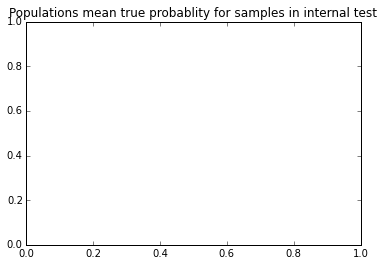

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('Populations mean true probablity for samples in internal test')
plt.hist(list(row_mean_prob.values()))
## row_mean_prob is the dictionary which holds per row true_p_variance.

Observation: Ideally, the graph should be as right skewed as possible. 


In [27]:
print("HOF Performance individually: ", predict_holdout([halloffame[0]]))
pop = offspring[:]
# pop = [halloffame[0]]


('HOF Performance individually: ', 0.81596452328159641)


-------
Some statistics on the final population


### Which row repeats and how many times.

In [37]:
import pandas as pd
def row_sampling():
    for ind_num, individual in enumerate(offspring):
        func = toolbox.compile(expr=individual)
    #     print individual
        sample_counts = [int(func(*record)) for record in X_train]
        sample_counts = [max(min(sample_count, max_features), 0) for sample_count in sample_counts]
        sample = []
        for sample_index, sample_count in enumerate(sample_counts):
            sample.extend([sample_index] * sample_count)
        sample = np.array(sample)
        print pd.Series(sample).value_counts().value_counts().index.tolist()
        print '\n'
        if ind_num==50:
            return
    

In [38]:
func = toolbox.compile(expr=offspring[1])

In [39]:
row_sampling()

[]


[3, 1, 2]


[1, 3, 2]


[1, 3, 2]


[1, 3, 2]


[1, 3, 2]


[3, 2, 1]


[3, 2]


[3]


[1]


[3, 2, 1]


[3, 1, 2]


[3, 1, 2]


[1, 3, 2]


[1]


[1, 3, 2]


[1, 2, 3]


[3]


[3, 1, 2]


[3, 1]


[3, 1, 2]


[3, 2]


[3, 1, 2]


[3, 2]


[3, 2, 1]


[3, 1, 2]


[3, 1, 2]


[1, 3, 2]


[3, 2]


[1, 3, 2]


[3, 1, 2]


[1, 3, 2]


[1, 3]


[1, 3, 2]


[3, 2]


[1, 3, 2]


[3, 1, 2]


[3, 2, 1]


[3]


[1, 3, 2]


[1, 3, 2]


[1, 3, 2]


[1]


[3, 2]


[3, 2, 1]


[1, 3, 2]


[1, 3, 2]


[3, 1, 2]


[1, 3, 2]


[3, 1, 2]


[1, 3, 2]




In [23]:
forest_predictions = []
subsample_sizes = []
for ind_num, individual in enumerate(offspring):
    func = toolbox.compile(expr=individual)
#     print individual
    sample_counts = [int(func(*record)) for record in X_train]
    sample_counts = [max(min(sample_count, max_features), 0) for sample_count in sample_counts]
    sample = []
    for sample_index, sample_count in enumerate(sample_counts):
        sample.extend([sample_index] * sample_count)
    sample = np.array(sample)
    
    if len(sample) == 0:
        continue
    
    subsample_sizes.append(len(sample))
    
    clf = DecisionTreeClassifier(random_state=34092)
    clf.fit(X_train[sample], y_train[sample])
    predictions = clf.predict(X_test_tot)
    forest_predictions.append(predictions)

ValueError: cannot convert float NaN to integer

In [100]:
from sklearn.metrics import accuracy_score

y_pred = np.array(
    [Counter(instance_forest_predictions).most_common(1)[0][0] for instance_forest_predictions in zip(*forest_predictions)])
np.sum(y_test_tot == y_pred)*1.0 / len(y_test_tot)

0.95565410199556544

In [102]:
pop = offspring[:]
import pandas as pd
fits = pd.DataFrame()
# fits['score'] = map(lambda x: x.fitness.values[0], pop)
fits['contrib_variance'] = [x.fitness.values[0] for x in pop]

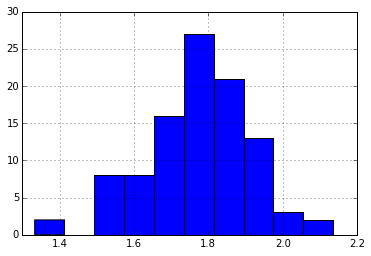

In [103]:
%matplotlib inline
fits.contrib_variance.hist()

3275.66
1516.77295743


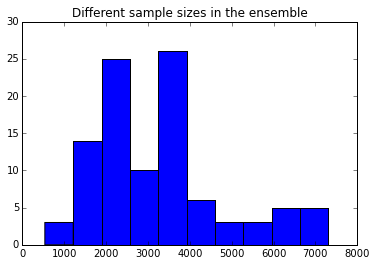

In [104]:
plt.title('Different sample sizes in the ensemble')
plt.hist(subsample_sizes)
print(np.mean(subsample_sizes))
print(np.std(subsample_sizes))


In [14]:

import pandas as pd
print("Mean # of unique labels predicted per sample by the ensemble.", pd.DataFrame(forest_predictions).apply(
    lambda x: len(x.unique()), axis=0).mean())

Mean # of unique labels predicted per sample by the ensemble. 5.35254988914


----

~ ~ ~ end of notebook - rough work follows ~ ~ ~

----

In [475]:
pd.DataFrame(forest_predictions)

,0,1,2,3,4,5,6,7,8,9,...,441,442,443,444,445,446,447,448,449,450
0,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
1,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
2,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
3,6,6,1,0,1,8,2,2,7,4,...,8,8,8,5,2,2,9,9,3,4
4,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
5,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,1
6,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
7,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
8,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,4
9,6,6,1,0,1,8,2,2,7,4,...,8,8,0,5,2,2,9,9,3,1


In [97]:
from sklearn import __version__

In [98]:
__version__

'0.17.1'

In [80]:
def random_forest_true_p(list_of_estimators):
    
    """
    pop is a list of indiv.
    Each indiv
    """
    row_mean_prob_ = {}
    row_prob_ = {}
    
    for tree in list_of_estimators:
    
        probas = tree.predict_proba(X_train_tot)
#         print clf.classes_
        for ix, row in enumerate(probas):
#             print row
            try:
                true_p = row[y_train_tot[ix]]
            except:
                true_p = np.nan
            try:
                row_prob_[ix].append(true_p)
            except:
                row_prob_[ix] = [true_p]
#                 print row_prob[ix]
    
#     print 'row_prob', row_prob
    for key in row_prob_.keys():
        row_mean_prob_[key] = np.nanmean(row_prob_[key])
    
    return row_mean_prob_
    

In [81]:

clf = RandomForestClassifier(random_state=34092, n_estimators=100)
clf.fit(X_train_tot, y_train_tot)
print('Base RandomForestClassifier accuracy: {}'.format(clf.score(X_test_tot, y_test_tot)))


Base RandomForestClassifier accuracy: 0.982261640798


In [82]:
# mean_dict = random_forest_true_p(clf.estimators_)
mean_dict = random_forest_true_p(clf.estimators_)

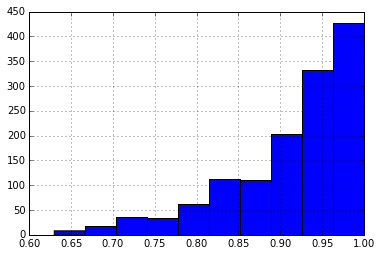

In [83]:
import pandas as pd
pd.Series(mean_dict.values()).hist()